# 난 스케치를 할 테니 너는 채색을 하거라

⭐️ pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다. 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.  
⭐️ pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.	U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.  
⭐️ 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다. 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

## 🎨 Import libraries & packages

In [1]:
# import useful tools
import os
import warnings
warnings.filterwarnings("ignore")

# import data tools
import numpy as np


# import visualize tools
import matplotlib.pyplot as plt


# import CV tools
import cv2


# import ML & DL tools
import tensorflow as tf
from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers

## 🎨 Define constants, frequently used variables, methods 

In [71]:
# data samples count
TOTAL_TRAIN_SAMPLES = 1000
TOTAL_VALID_SAMPLES = 5


# image data normalization
RGB_HALF_VALUE = 127.5    # 256 / 2 = 127.5


# training configuratinos
EPOCHS = 100


# path of image datasets
data_path = os.getenv("HOME") + "/aiffel/conditional_generation/data/cityscapes/"
train_data_path = data_path + "train/"
valid_data_path = data_path + "val/"


# print text divider ("===")
DIVIDER_LENGTH = 80
def print_divider():
    print("=" * DIVIDER_LENGTH)

---

## 🎨 Define data pre-processing methods

### 1. Define data loading method

In [3]:
def load_img_data(img_path):
    # load image file
    img = tf.io.read_file(img_path)
    
    # convert image data as tensors
    img = tf.image.decode_image(img, 3)
    
    
    # split image into two parts -> segmented image (left) & original image (right)
    w = tf.shape(img)[1] // 2    # half size of total width
        
    segmented = img[:, w:, :] 
    #segmented = tf.cast(segmented, tf.float32)
    
    original = img[:, :w, :] 
    #original = tf.cast(original, tf.float32)
    
    return segmented, original

### 2. Define normalization methods

In [4]:
# normalize image tensor data from range (0, 255) to range (-1, 1)
def normalize_img_data(img_data):
    img_data = tf.cast(img_data, tf.float32)
    img_data = (img_data / RGB_HALF_VALUE) - 1
    return img_data


# normalize two image tensor data pair (input, target pair)
def normalize_img_data_pair(segmented, original):
    normalized_segmented = normalize_img_data(segmented)
    normalized_original = normalize_img_data(original)
    return normalized_segmented, normalized_original


# recover normalized image tensor data from range (-1, 1) to range (0, 255) 
def denormalize_img_data(img_data):
    img_data = (img_data + 1) * RGB_HALF_VALUE
    img_data = img_data.numpy()
    img_data = img_data.astype(np.uint8)
    return img_data


# recover two normalized image tensor data pair (input, target pair)
def denormalize_img_data_pair(segmented, original):
    denormalized_segmented = denormalize_img_data(segmented)
    denormalized_original = denormalize_img_data(original)
    return denormalized_segmented, denormalized_original

### 3. Define augmentation methods

In [5]:
@tf.function() # for quick tensorflow computation 
def apply_augmentation(segmented, original):
    # concatenate segmented & original image data
    stacked = tf.concat([segmented, original], axis = -1)
    
    # padding
    _pad = tf.constant([[30,30], [30,30], [0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values = 1.)

    # crop
    augmented = image.random_crop(padded, size=[256, 256, 6])
    
    # flip
    augmented = image.random_flip_left_right(augmented)
    augmented = image.random_flip_up_down(augmented)
    
    # rotation
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval = 1, maxval = 4, dtype = tf.int32)
        augmented = image.rot90(augmented, k = degree)
    
    # split into segmented & original image data
    augmented_segmented = augmented[..., :3]
    augmented_original = augmented[..., 3:]
    
    return augmented_segmented, augmented_original

### 4. Define data load & pre-process & augmentation pipeline method 

In [8]:
def get_img_data_pipeline(img_path):
    # load image data
    segmented, original = load_img_data(img_path)
    
    # normalize image data values
    segmented, original = normalize_img_data_pair(segmented, original)
    
    # augment image data
    segmented, original = apply_augmentation(segmented, original)
    
    return segmented, original

## 🎨 Load data & perform pre-processing

### 1. Load data & perform pre-processing

In [9]:
# get list of filenames of image data
train_img_data = data.Dataset.list_files(train_data_path + "*.jpg")
total_train_samples = len(train_img_data)


# load data and prepare for learning (pre-processing)
# 1. load image data
# 2. split into input & target data
# 3. normalization
# 4. augmentation
train_img_data = train_img_data.map(get_img_data_pipeline).shuffle(100).batch(4)


print(">>> Total", total_train_samples, "image data pairs are loaded and prepared.")
#print(np.array(list(train_img_data.as_numpy_iterator())).shape)

>>> Total 1000 image data pairs are loaded and prepared.


### 2. Preview sample images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Preview of train image data 181.jpg


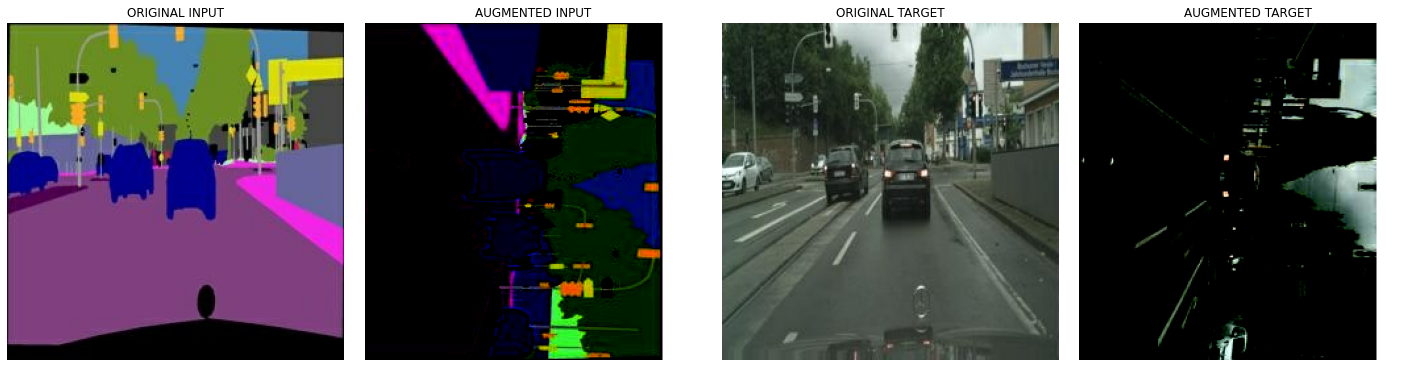

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Preview of train image data 908.jpg


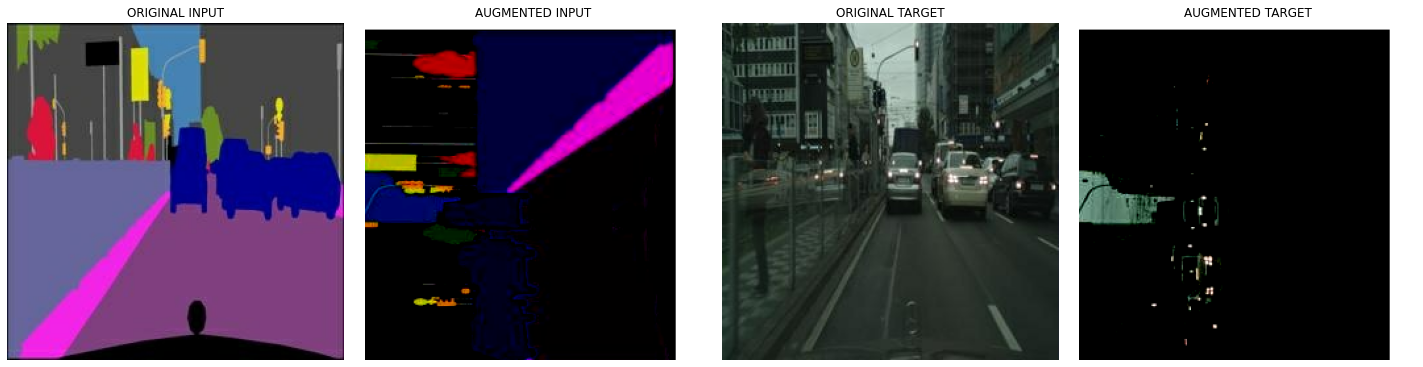

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Preview of train image data 49.jpg


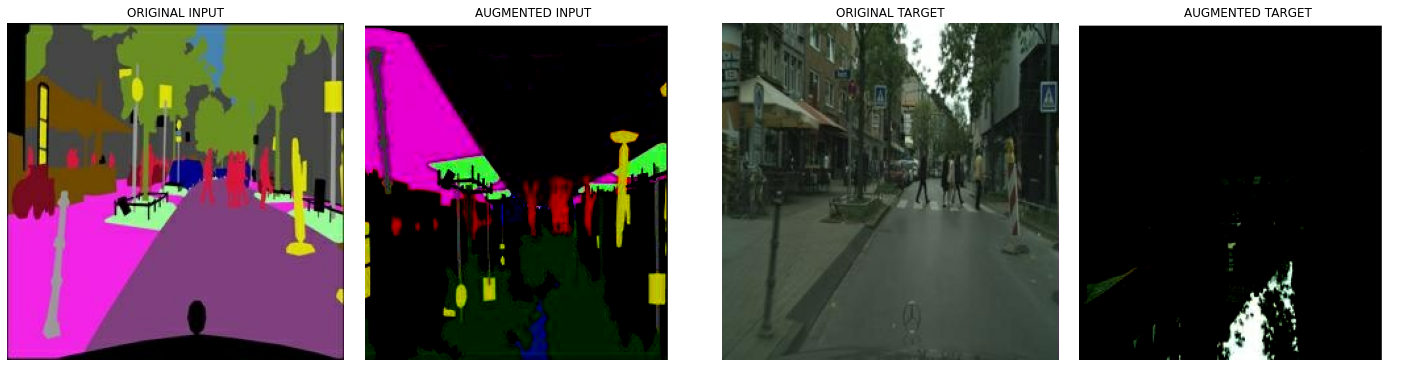

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Preview of train image data 337.jpg


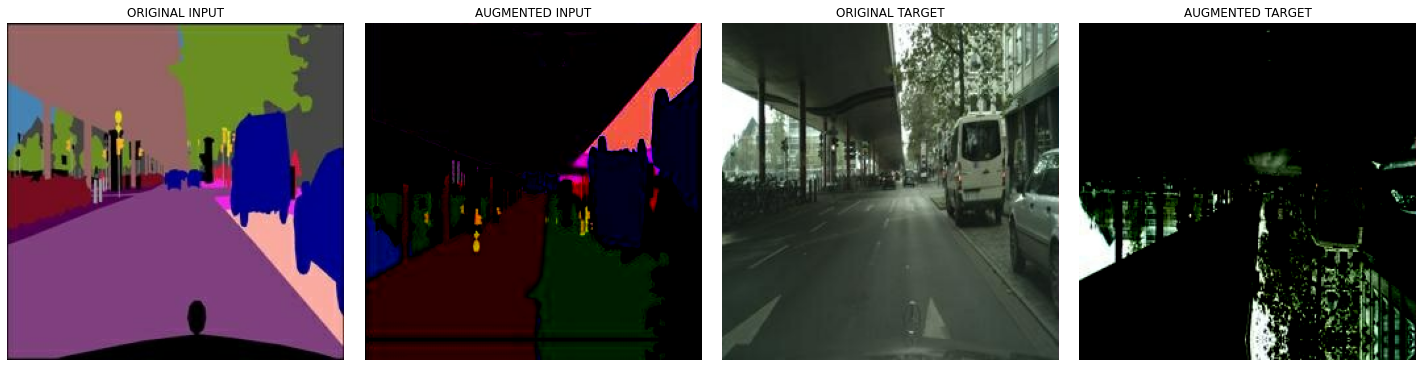

In [10]:
for i in range(4):
    # get random train data image filename
    filename = train_data_path + os.listdir(train_data_path)[np.random.randint(TOTAL_TRAIN_SAMPLES)]
    
    
    # raw image data
    raw_segmented, raw_original = load_img_data(filename)
    
    # normalized data (not available to visualize)
    normalized_segmented, normalized_original = normalize_img_data_pair(raw_segmented, raw_original)
    
    # augmented normalized data (nor available to visualize)
    augmented_segmented, augmented_original = apply_augmentation(normalized_segmented, normalized_original)
    
    # denormalized augmented normalized data
    denormalized_segmented, denormalized_original = denormalize_img_data_pair(augmented_segmented, augmented_original)
    
    
    
    # display image data
    print("Preview of train image data", filename[len(train_data_path):])
    
    preview_fig = plt.figure(figsize = (20,5))
    
    subfig1 = preview_fig.add_subplot(1, 4, 1)
    subfig1.imshow(raw_segmented)
    subfig1.set_title("ORIGINAL INPUT")
    subfig1.axis("off")
    
    subfig2 = preview_fig.add_subplot(1, 4, 2)
    subfig2.imshow(augmented_segmented)
    subfig2.set_title("AUGMENTED INPUT")
    subfig2.axis("off")
    
    subfig3 = preview_fig.add_subplot(1, 4, 3)
    subfig3.imshow(raw_original)
    subfig3.set_title("ORIGINAL TARGET")
    subfig3.axis("off")
    
    subfig4 = preview_fig.add_subplot(1, 4, 4)
    subfig4.imshow(augmented_original)
    subfig4.set_title("AUGMENTED TARGET")
    subfig4.axis("off")
    
    plt.tight_layout()
    plt.show()

---

## 🎨 Implement cGAN model

### 1. Implement generator

1-1. Define ENCODER layer class

In [38]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn = True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

1-2. Define DECODER layer class

In [39]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout = True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

1-3. Buld U-Net generator by connecting ENCODER & DECODER with skip connections

In [40]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn = False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout = False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias = False)
    
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
        
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [41]:
# check layer structure of U-Net generator
UNetGenerator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_72 (EncodeBlock)   (None, 128, 128, 64) 3072        input_10[0][0]                   
__________________________________________________________________________________________________
encode_block_73 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_72[0][0]            
__________________________________________________________________________________________________
encode_block_74 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_73[0][0]            
____________________________________________________________________________________________

### 2. Implement Discriminator

2-1. Define discriminator layer class

In [58]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [59]:
# check output size of each output from each layer

# simulate layer constructure
inputs = Input((128,128,32))
outputs = layers.ZeroPadding2D()(inputs)
outputs = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(outputs)
outputs = layers.BatchNormalization()(outputs)
outputs = layers.LeakyReLU(0.2)(outputs)

# display output shape
Model(inputs, outputs).summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_218 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_134 (LeakyReLU)  (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [60]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        for i in range(len(filters)):
            if i == 0:
                self.blocks.append(DiscBlock(filters[i], stride = 2, custom_pad = False, use_bn = False, act = True))
            elif i == 1 or i == 2:
                self.blocks.append(DiscBlock(filters[i], stride = 2, custom_pad = False, use_bn = True, act = True))
            elif i == 3:
                self.blocks.append(DiscBlock(filters[i], stride = 1, custom_pad = True, use_bn = True, act = True))
            else: # i == 4:
                self.blocks.append(DiscBlock(filters[i], stride = 1, custom_pad = True, use_bn = False, act = False))
        
        self.sigmoid = layers.Activation('sigmoid')


    def call(self, x, y):
        out = self.blocks[0]([x, y])
        
        for block in self.blocks[1:]:
            out = block(out)

        return self.sigmoid(out)

    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

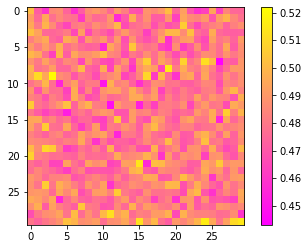

In [61]:
# check operation of defined discriminator model with random inputs

# define random inputs
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

# get output of discriminator
disc_out = Discriminator()(x, y)

# visualize result
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()
plt.spring()

### 3. Define loss functions

3-1. Define loss 

In [62]:
# define frequently used loss functions as short term
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()


# define method to calculate generator's loss, and additional L1 loss
def get_gene_loss(fake_output, real_output, fake_disc):
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    l1_loss = mae(real_output, fake_output)
    return gene_loss, l1_loss


# define method to calculate discriminator's loss
def get_disc_loss(fake_disc, real_disc):
    disc_loss = bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)
    return disc_loss

3-2. Define optimizers (following the originally suggested paper)

In [63]:
gene_opt = optimizers.Adam(2e-4, beta_1 = .5, beta_2 = .999)
disc_opt = optimizers.Adam(2e-4, beta_1 = .5, beta_2 = .999)

3-3. Define weight update method ()

In [64]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # get prediction by generator
        fake_colored = generator(sketch, training=True)
        
        # get prediction by discriminator
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        
        # calculate generator loss
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        
        # calculate discriminator loss
        disc_loss = get_disc_loss(fake_disc, real_disc)

        
    gene_gradient = gene_tape.gradient(gene_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    
    return gene_loss, l1_loss, disc_loss

---

## 🎨 Test performance of cGAN model

### 1. Model training

In [66]:
# generate generator & discriminator model instances
generator = UNetGenerator()
discriminator = Discriminator()


# perform training & print estimated loss
for ep in range(1, EPOCHS + 1):
    for i, (segmented, original) in enumerate(train_img_data):
        g_loss, l1_loss, d_loss = train_step(segmented, original)
                
        # print loss by 10 iteration
        if (i + 1) % 10 == 0:
            print(f">>> EPOCH[{ep}] - STEP[{i + 1}] \
                    \n    Generator_loss     : {g_loss.numpy():.4f} \
                    \n    L1 loss            : {l1_loss.numpy():.4f} \
                    \n    Discriminator loss : {d_loss.numpy():.4f}", end = "\n\n")

>>> EPOCH[1] - STEP[10]                     
    Generator_loss     : 0.8822                     
    L1 loss            : 0.5507                     
    Discriminator loss : 1.2460

>>> EPOCH[1] - STEP[20]                     
    Generator_loss     : 0.8787                     
    L1 loss            : 0.5246                     
    Discriminator loss : 1.2485

>>> EPOCH[1] - STEP[30]                     
    Generator_loss     : 1.0747                     
    L1 loss            : 0.5907                     
    Discriminator loss : 1.5215

>>> EPOCH[1] - STEP[40]                     
    Generator_loss     : 0.8769                     
    L1 loss            : 0.4281                     
    Discriminator loss : 1.1575

>>> EPOCH[1] - STEP[50]                     
    Generator_loss     : 0.8680                     
    L1 loss            : 0.3851                     
    Discriminator loss : 1.3779

>>> EPOCH[1] - STEP[60]                     
    Generator_loss     : 0.7567    

>>> EPOCH[2] - STEP[210]                     
    Generator_loss     : 1.0914                     
    L1 loss            : 0.3203                     
    Discriminator loss : 1.1329

>>> EPOCH[2] - STEP[220]                     
    Generator_loss     : 0.8953                     
    L1 loss            : 0.2141                     
    Discriminator loss : 1.3035

>>> EPOCH[2] - STEP[230]                     
    Generator_loss     : 0.9584                     
    L1 loss            : 0.2963                     
    Discriminator loss : 1.4268

>>> EPOCH[2] - STEP[240]                     
    Generator_loss     : 0.8994                     
    L1 loss            : 0.2956                     
    Discriminator loss : 1.2431

>>> EPOCH[2] - STEP[250]                     
    Generator_loss     : 1.2722                     
    L1 loss            : 0.2860                     
    Discriminator loss : 1.2952

>>> EPOCH[3] - STEP[10]                     
    Generator_loss     : 0.935

>>> EPOCH[4] - STEP[160]                     
    Generator_loss     : 0.7935                     
    L1 loss            : 0.2731                     
    Discriminator loss : 1.0278

>>> EPOCH[4] - STEP[170]                     
    Generator_loss     : 0.6927                     
    L1 loss            : 0.2606                     
    Discriminator loss : 1.2918

>>> EPOCH[4] - STEP[180]                     
    Generator_loss     : 0.9871                     
    L1 loss            : 0.2604                     
    Discriminator loss : 1.1245

>>> EPOCH[4] - STEP[190]                     
    Generator_loss     : 1.6063                     
    L1 loss            : 0.2846                     
    Discriminator loss : 1.4758

>>> EPOCH[4] - STEP[200]                     
    Generator_loss     : 1.1855                     
    L1 loss            : 0.3060                     
    Discriminator loss : 1.1293

>>> EPOCH[4] - STEP[210]                     
    Generator_loss     : 0.82

>>> EPOCH[6] - STEP[110]                     
    Generator_loss     : 1.0838                     
    L1 loss            : 0.3008                     
    Discriminator loss : 1.1007

>>> EPOCH[6] - STEP[120]                     
    Generator_loss     : 0.5061                     
    L1 loss            : 0.2838                     
    Discriminator loss : 1.4853

>>> EPOCH[6] - STEP[130]                     
    Generator_loss     : 1.1045                     
    L1 loss            : 0.2361                     
    Discriminator loss : 1.3700

>>> EPOCH[6] - STEP[140]                     
    Generator_loss     : 0.7636                     
    L1 loss            : 0.3180                     
    Discriminator loss : 1.1223

>>> EPOCH[6] - STEP[150]                     
    Generator_loss     : 1.7395                     
    L1 loss            : 0.2072                     
    Discriminator loss : 1.5363

>>> EPOCH[6] - STEP[160]                     
    Generator_loss     : 0.89

>>> EPOCH[8] - STEP[60]                     
    Generator_loss     : 0.7339                     
    L1 loss            : 0.2091                     
    Discriminator loss : 1.2942

>>> EPOCH[8] - STEP[70]                     
    Generator_loss     : 0.8722                     
    L1 loss            : 0.2088                     
    Discriminator loss : 1.3785

>>> EPOCH[8] - STEP[80]                     
    Generator_loss     : 1.1341                     
    L1 loss            : 0.3003                     
    Discriminator loss : 1.3130

>>> EPOCH[8] - STEP[90]                     
    Generator_loss     : 1.0437                     
    L1 loss            : 0.2460                     
    Discriminator loss : 1.3112

>>> EPOCH[8] - STEP[100]                     
    Generator_loss     : 0.8839                     
    L1 loss            : 0.2701                     
    Discriminator loss : 1.3411

>>> EPOCH[8] - STEP[110]                     
    Generator_loss     : 0.8097  

>>> EPOCH[10] - STEP[10]                     
    Generator_loss     : 0.8035                     
    L1 loss            : 0.2318                     
    Discriminator loss : 1.1993

>>> EPOCH[10] - STEP[20]                     
    Generator_loss     : 0.8886                     
    L1 loss            : 0.2090                     
    Discriminator loss : 1.1318

>>> EPOCH[10] - STEP[30]                     
    Generator_loss     : 0.8187                     
    L1 loss            : 0.2634                     
    Discriminator loss : 1.2072

>>> EPOCH[10] - STEP[40]                     
    Generator_loss     : 0.8744                     
    L1 loss            : 0.2360                     
    Discriminator loss : 1.2850

>>> EPOCH[10] - STEP[50]                     
    Generator_loss     : 0.9132                     
    L1 loss            : 0.2455                     
    Discriminator loss : 1.1826

>>> EPOCH[10] - STEP[60]                     
    Generator_loss     : 0.66

>>> EPOCH[11] - STEP[210]                     
    Generator_loss     : 0.8912                     
    L1 loss            : 0.2455                     
    Discriminator loss : 1.1296

>>> EPOCH[11] - STEP[220]                     
    Generator_loss     : 0.9059                     
    L1 loss            : 0.2528                     
    Discriminator loss : 1.2854

>>> EPOCH[11] - STEP[230]                     
    Generator_loss     : 1.0016                     
    L1 loss            : 0.2445                     
    Discriminator loss : 1.1528

>>> EPOCH[11] - STEP[240]                     
    Generator_loss     : 1.5232                     
    L1 loss            : 0.2718                     
    Discriminator loss : 1.2819

>>> EPOCH[11] - STEP[250]                     
    Generator_loss     : 1.0335                     
    L1 loss            : 0.2401                     
    Discriminator loss : 1.1124

>>> EPOCH[12] - STEP[10]                     
    Generator_loss     :

>>> EPOCH[13] - STEP[160]                     
    Generator_loss     : 1.0578                     
    L1 loss            : 0.2590                     
    Discriminator loss : 1.1554

>>> EPOCH[13] - STEP[170]                     
    Generator_loss     : 1.1354                     
    L1 loss            : 0.2356                     
    Discriminator loss : 1.1468

>>> EPOCH[13] - STEP[180]                     
    Generator_loss     : 1.0644                     
    L1 loss            : 0.3456                     
    Discriminator loss : 0.7895

>>> EPOCH[13] - STEP[190]                     
    Generator_loss     : 1.0121                     
    L1 loss            : 0.3445                     
    Discriminator loss : 0.9084

>>> EPOCH[13] - STEP[200]                     
    Generator_loss     : 1.0519                     
    L1 loss            : 0.1957                     
    Discriminator loss : 1.2481

>>> EPOCH[13] - STEP[210]                     
    Generator_loss     

>>> EPOCH[15] - STEP[110]                     
    Generator_loss     : 1.0546                     
    L1 loss            : 0.1955                     
    Discriminator loss : 1.1039

>>> EPOCH[15] - STEP[120]                     
    Generator_loss     : 0.7296                     
    L1 loss            : 0.2777                     
    Discriminator loss : 1.3349

>>> EPOCH[15] - STEP[130]                     
    Generator_loss     : 1.0581                     
    L1 loss            : 0.2467                     
    Discriminator loss : 1.0375

>>> EPOCH[15] - STEP[140]                     
    Generator_loss     : 0.8688                     
    L1 loss            : 0.2427                     
    Discriminator loss : 1.1194

>>> EPOCH[15] - STEP[150]                     
    Generator_loss     : 1.0783                     
    L1 loss            : 0.2092                     
    Discriminator loss : 1.3164

>>> EPOCH[15] - STEP[160]                     
    Generator_loss     

>>> EPOCH[17] - STEP[60]                     
    Generator_loss     : 0.7784                     
    L1 loss            : 0.2633                     
    Discriminator loss : 1.1646

>>> EPOCH[17] - STEP[70]                     
    Generator_loss     : 0.6727                     
    L1 loss            : 0.2518                     
    Discriminator loss : 1.2377

>>> EPOCH[17] - STEP[80]                     
    Generator_loss     : 0.9283                     
    L1 loss            : 0.2746                     
    Discriminator loss : 1.1340

>>> EPOCH[17] - STEP[90]                     
    Generator_loss     : 1.0930                     
    L1 loss            : 0.3446                     
    Discriminator loss : 1.0100

>>> EPOCH[17] - STEP[100]                     
    Generator_loss     : 0.7787                     
    L1 loss            : 0.2235                     
    Discriminator loss : 1.3517

>>> EPOCH[17] - STEP[110]                     
    Generator_loss     : 0.

>>> EPOCH[19] - STEP[10]                     
    Generator_loss     : 1.3022                     
    L1 loss            : 0.2075                     
    Discriminator loss : 1.5183

>>> EPOCH[19] - STEP[20]                     
    Generator_loss     : 1.0575                     
    L1 loss            : 0.2584                     
    Discriminator loss : 1.0394

>>> EPOCH[19] - STEP[30]                     
    Generator_loss     : 0.8847                     
    L1 loss            : 0.2264                     
    Discriminator loss : 1.2683

>>> EPOCH[19] - STEP[40]                     
    Generator_loss     : 1.0965                     
    L1 loss            : 0.2514                     
    Discriminator loss : 1.0610

>>> EPOCH[19] - STEP[50]                     
    Generator_loss     : 1.0786                     
    L1 loss            : 0.2126                     
    Discriminator loss : 1.2614

>>> EPOCH[19] - STEP[60]                     
    Generator_loss     : 0.95

>>> EPOCH[20] - STEP[210]                     
    Generator_loss     : 1.6672                     
    L1 loss            : 0.2015                     
    Discriminator loss : 1.3134

>>> EPOCH[20] - STEP[220]                     
    Generator_loss     : 1.1176                     
    L1 loss            : 0.2184                     
    Discriminator loss : 0.8510

>>> EPOCH[20] - STEP[230]                     
    Generator_loss     : 1.2804                     
    L1 loss            : 0.2525                     
    Discriminator loss : 1.0777

>>> EPOCH[20] - STEP[240]                     
    Generator_loss     : 0.9565                     
    L1 loss            : 0.2418                     
    Discriminator loss : 1.1007

>>> EPOCH[20] - STEP[250]                     
    Generator_loss     : 0.9766                     
    L1 loss            : 0.2715                     
    Discriminator loss : 1.0621

>>> EPOCH[21] - STEP[10]                     
    Generator_loss     :

>>> EPOCH[22] - STEP[160]                     
    Generator_loss     : 1.3067                     
    L1 loss            : 0.1947                     
    Discriminator loss : 1.1982

>>> EPOCH[22] - STEP[170]                     
    Generator_loss     : 1.0200                     
    L1 loss            : 0.2406                     
    Discriminator loss : 0.9012

>>> EPOCH[22] - STEP[180]                     
    Generator_loss     : 1.4722                     
    L1 loss            : 0.2318                     
    Discriminator loss : 0.8108

>>> EPOCH[22] - STEP[190]                     
    Generator_loss     : 0.9967                     
    L1 loss            : 0.2388                     
    Discriminator loss : 0.9183

>>> EPOCH[22] - STEP[200]                     
    Generator_loss     : 0.6762                     
    L1 loss            : 0.2135                     
    Discriminator loss : 1.2893

>>> EPOCH[22] - STEP[210]                     
    Generator_loss     

>>> EPOCH[24] - STEP[110]                     
    Generator_loss     : 1.4020                     
    L1 loss            : 0.2701                     
    Discriminator loss : 1.3303

>>> EPOCH[24] - STEP[120]                     
    Generator_loss     : 1.0787                     
    L1 loss            : 0.2180                     
    Discriminator loss : 0.9191

>>> EPOCH[24] - STEP[130]                     
    Generator_loss     : 1.4438                     
    L1 loss            : 0.2144                     
    Discriminator loss : 1.6468

>>> EPOCH[24] - STEP[140]                     
    Generator_loss     : 1.2671                     
    L1 loss            : 0.2503                     
    Discriminator loss : 0.7671

>>> EPOCH[24] - STEP[150]                     
    Generator_loss     : 1.2880                     
    L1 loss            : 0.2383                     
    Discriminator loss : 1.8763

>>> EPOCH[24] - STEP[160]                     
    Generator_loss     

>>> EPOCH[26] - STEP[60]                     
    Generator_loss     : 1.0782                     
    L1 loss            : 0.2590                     
    Discriminator loss : 1.0789

>>> EPOCH[26] - STEP[70]                     
    Generator_loss     : 1.1272                     
    L1 loss            : 0.2748                     
    Discriminator loss : 1.1415

>>> EPOCH[26] - STEP[80]                     
    Generator_loss     : 0.9352                     
    L1 loss            : 0.2365                     
    Discriminator loss : 1.4797

>>> EPOCH[26] - STEP[90]                     
    Generator_loss     : 1.1455                     
    L1 loss            : 0.2427                     
    Discriminator loss : 0.9965

>>> EPOCH[26] - STEP[100]                     
    Generator_loss     : 1.3718                     
    L1 loss            : 0.2479                     
    Discriminator loss : 0.9864

>>> EPOCH[26] - STEP[110]                     
    Generator_loss     : 1.

>>> EPOCH[28] - STEP[10]                     
    Generator_loss     : 0.6355                     
    L1 loss            : 0.2239                     
    Discriminator loss : 1.4044

>>> EPOCH[28] - STEP[20]                     
    Generator_loss     : 1.5978                     
    L1 loss            : 0.2198                     
    Discriminator loss : 1.1525

>>> EPOCH[28] - STEP[30]                     
    Generator_loss     : 1.0326                     
    L1 loss            : 0.2218                     
    Discriminator loss : 1.2001

>>> EPOCH[28] - STEP[40]                     
    Generator_loss     : 0.5428                     
    L1 loss            : 0.2251                     
    Discriminator loss : 1.3508

>>> EPOCH[28] - STEP[50]                     
    Generator_loss     : 1.3560                     
    L1 loss            : 0.2421                     
    Discriminator loss : 1.2711

>>> EPOCH[28] - STEP[60]                     
    Generator_loss     : 1.27

>>> EPOCH[29] - STEP[210]                     
    Generator_loss     : 0.8866                     
    L1 loss            : 0.2766                     
    Discriminator loss : 1.1710

>>> EPOCH[29] - STEP[220]                     
    Generator_loss     : 0.5322                     
    L1 loss            : 0.2231                     
    Discriminator loss : 1.2619

>>> EPOCH[29] - STEP[230]                     
    Generator_loss     : 0.9813                     
    L1 loss            : 0.2223                     
    Discriminator loss : 1.1757

>>> EPOCH[29] - STEP[240]                     
    Generator_loss     : 0.7484                     
    L1 loss            : 0.2627                     
    Discriminator loss : 1.0703

>>> EPOCH[29] - STEP[250]                     
    Generator_loss     : 0.7203                     
    L1 loss            : 0.1868                     
    Discriminator loss : 1.0676

>>> EPOCH[30] - STEP[10]                     
    Generator_loss     :

>>> EPOCH[31] - STEP[160]                     
    Generator_loss     : 0.8081                     
    L1 loss            : 0.1847                     
    Discriminator loss : 1.2795

>>> EPOCH[31] - STEP[170]                     
    Generator_loss     : 0.6922                     
    L1 loss            : 0.2154                     
    Discriminator loss : 1.3411

>>> EPOCH[31] - STEP[180]                     
    Generator_loss     : 1.1124                     
    L1 loss            : 0.2378                     
    Discriminator loss : 1.0404

>>> EPOCH[31] - STEP[190]                     
    Generator_loss     : 1.3544                     
    L1 loss            : 0.4123                     
    Discriminator loss : 0.9705

>>> EPOCH[31] - STEP[200]                     
    Generator_loss     : 1.8745                     
    L1 loss            : 0.2019                     
    Discriminator loss : 1.5145

>>> EPOCH[31] - STEP[210]                     
    Generator_loss     

>>> EPOCH[33] - STEP[110]                     
    Generator_loss     : 0.9819                     
    L1 loss            : 0.2300                     
    Discriminator loss : 1.1219

>>> EPOCH[33] - STEP[120]                     
    Generator_loss     : 0.6726                     
    L1 loss            : 0.2111                     
    Discriminator loss : 1.5522

>>> EPOCH[33] - STEP[130]                     
    Generator_loss     : 0.6292                     
    L1 loss            : 0.2112                     
    Discriminator loss : 1.6191

>>> EPOCH[33] - STEP[140]                     
    Generator_loss     : 1.0787                     
    L1 loss            : 0.1957                     
    Discriminator loss : 1.2561

>>> EPOCH[33] - STEP[150]                     
    Generator_loss     : 1.0446                     
    L1 loss            : 0.2586                     
    Discriminator loss : 1.0523

>>> EPOCH[33] - STEP[160]                     
    Generator_loss     

>>> EPOCH[35] - STEP[60]                     
    Generator_loss     : 0.9865                     
    L1 loss            : 0.2005                     
    Discriminator loss : 1.2619

>>> EPOCH[35] - STEP[70]                     
    Generator_loss     : 1.6539                     
    L1 loss            : 0.2405                     
    Discriminator loss : 1.9159

>>> EPOCH[35] - STEP[80]                     
    Generator_loss     : 0.9024                     
    L1 loss            : 0.2440                     
    Discriminator loss : 1.4527

>>> EPOCH[35] - STEP[90]                     
    Generator_loss     : 1.4161                     
    L1 loss            : 0.2673                     
    Discriminator loss : 1.1530

>>> EPOCH[35] - STEP[100]                     
    Generator_loss     : 0.9032                     
    L1 loss            : 0.2097                     
    Discriminator loss : 1.2413

>>> EPOCH[35] - STEP[110]                     
    Generator_loss     : 0.

>>> EPOCH[37] - STEP[10]                     
    Generator_loss     : 1.2561                     
    L1 loss            : 0.2055                     
    Discriminator loss : 1.2610

>>> EPOCH[37] - STEP[20]                     
    Generator_loss     : 0.4149                     
    L1 loss            : 0.2758                     
    Discriminator loss : 1.6580

>>> EPOCH[37] - STEP[30]                     
    Generator_loss     : 0.3470                     
    L1 loss            : 0.2359                     
    Discriminator loss : 1.6138

>>> EPOCH[37] - STEP[40]                     
    Generator_loss     : 1.4046                     
    L1 loss            : 0.2152                     
    Discriminator loss : 1.0233

>>> EPOCH[37] - STEP[50]                     
    Generator_loss     : 0.7088                     
    L1 loss            : 0.2402                     
    Discriminator loss : 1.3130

>>> EPOCH[37] - STEP[60]                     
    Generator_loss     : 0.47

>>> EPOCH[38] - STEP[210]                     
    Generator_loss     : 1.0438                     
    L1 loss            : 0.1982                     
    Discriminator loss : 0.9854

>>> EPOCH[38] - STEP[220]                     
    Generator_loss     : 0.8126                     
    L1 loss            : 0.2710                     
    Discriminator loss : 1.6668

>>> EPOCH[38] - STEP[230]                     
    Generator_loss     : 0.5015                     
    L1 loss            : 0.2475                     
    Discriminator loss : 1.7608

>>> EPOCH[38] - STEP[240]                     
    Generator_loss     : 1.2641                     
    L1 loss            : 0.2462                     
    Discriminator loss : 0.9806

>>> EPOCH[38] - STEP[250]                     
    Generator_loss     : 1.0451                     
    L1 loss            : 0.2183                     
    Discriminator loss : 1.0897

>>> EPOCH[39] - STEP[10]                     
    Generator_loss     :

>>> EPOCH[40] - STEP[160]                     
    Generator_loss     : 0.7544                     
    L1 loss            : 0.1841                     
    Discriminator loss : 1.4455

>>> EPOCH[40] - STEP[170]                     
    Generator_loss     : 0.9764                     
    L1 loss            : 0.2189                     
    Discriminator loss : 1.4316

>>> EPOCH[40] - STEP[180]                     
    Generator_loss     : 0.6972                     
    L1 loss            : 0.2424                     
    Discriminator loss : 1.3964

>>> EPOCH[40] - STEP[190]                     
    Generator_loss     : 0.8219                     
    L1 loss            : 0.2299                     
    Discriminator loss : 1.1644

>>> EPOCH[40] - STEP[200]                     
    Generator_loss     : 0.8803                     
    L1 loss            : 0.2210                     
    Discriminator loss : 1.1948

>>> EPOCH[40] - STEP[210]                     
    Generator_loss     

>>> EPOCH[42] - STEP[110]                     
    Generator_loss     : 0.8085                     
    L1 loss            : 0.2339                     
    Discriminator loss : 1.3160

>>> EPOCH[42] - STEP[120]                     
    Generator_loss     : 0.5047                     
    L1 loss            : 0.2005                     
    Discriminator loss : 1.5147

>>> EPOCH[42] - STEP[130]                     
    Generator_loss     : 0.9069                     
    L1 loss            : 0.2424                     
    Discriminator loss : 1.3383

>>> EPOCH[42] - STEP[140]                     
    Generator_loss     : 0.8372                     
    L1 loss            : 0.2124                     
    Discriminator loss : 1.3538

>>> EPOCH[42] - STEP[150]                     
    Generator_loss     : 0.9302                     
    L1 loss            : 0.2209                     
    Discriminator loss : 1.5758

>>> EPOCH[42] - STEP[160]                     
    Generator_loss     

>>> EPOCH[44] - STEP[60]                     
    Generator_loss     : 0.6367                     
    L1 loss            : 0.2221                     
    Discriminator loss : 1.6205

>>> EPOCH[44] - STEP[70]                     
    Generator_loss     : 0.9530                     
    L1 loss            : 0.2377                     
    Discriminator loss : 1.1683

>>> EPOCH[44] - STEP[80]                     
    Generator_loss     : 1.1459                     
    L1 loss            : 0.2477                     
    Discriminator loss : 0.9796

>>> EPOCH[44] - STEP[90]                     
    Generator_loss     : 0.9517                     
    L1 loss            : 0.2453                     
    Discriminator loss : 1.1334

>>> EPOCH[44] - STEP[100]                     
    Generator_loss     : 0.8913                     
    L1 loss            : 0.2195                     
    Discriminator loss : 1.5623

>>> EPOCH[44] - STEP[110]                     
    Generator_loss     : 0.

>>> EPOCH[46] - STEP[10]                     
    Generator_loss     : 0.7401                     
    L1 loss            : 0.2655                     
    Discriminator loss : 1.2567

>>> EPOCH[46] - STEP[20]                     
    Generator_loss     : 0.8209                     
    L1 loss            : 0.2620                     
    Discriminator loss : 1.0627

>>> EPOCH[46] - STEP[30]                     
    Generator_loss     : 0.4663                     
    L1 loss            : 0.2464                     
    Discriminator loss : 1.5247

>>> EPOCH[46] - STEP[40]                     
    Generator_loss     : 0.8558                     
    L1 loss            : 0.2109                     
    Discriminator loss : 1.1039

>>> EPOCH[46] - STEP[50]                     
    Generator_loss     : 0.7457                     
    L1 loss            : 0.2276                     
    Discriminator loss : 1.1499

>>> EPOCH[46] - STEP[60]                     
    Generator_loss     : 1.06

>>> EPOCH[47] - STEP[210]                     
    Generator_loss     : 0.7304                     
    L1 loss            : 0.2112                     
    Discriminator loss : 1.3340

>>> EPOCH[47] - STEP[220]                     
    Generator_loss     : 0.6332                     
    L1 loss            : 0.2211                     
    Discriminator loss : 1.2167

>>> EPOCH[47] - STEP[230]                     
    Generator_loss     : 0.7246                     
    L1 loss            : 0.2215                     
    Discriminator loss : 1.3563

>>> EPOCH[47] - STEP[240]                     
    Generator_loss     : 0.8638                     
    L1 loss            : 0.2445                     
    Discriminator loss : 0.9853

>>> EPOCH[47] - STEP[250]                     
    Generator_loss     : 0.8331                     
    L1 loss            : 0.2852                     
    Discriminator loss : 1.1528

>>> EPOCH[48] - STEP[10]                     
    Generator_loss     :

>>> EPOCH[49] - STEP[160]                     
    Generator_loss     : 0.5689                     
    L1 loss            : 0.2499                     
    Discriminator loss : 1.6364

>>> EPOCH[49] - STEP[170]                     
    Generator_loss     : 0.6939                     
    L1 loss            : 0.2880                     
    Discriminator loss : 1.2181

>>> EPOCH[49] - STEP[180]                     
    Generator_loss     : 1.2880                     
    L1 loss            : 0.2200                     
    Discriminator loss : 1.2782

>>> EPOCH[49] - STEP[190]                     
    Generator_loss     : 0.6318                     
    L1 loss            : 0.2032                     
    Discriminator loss : 1.4624

>>> EPOCH[49] - STEP[200]                     
    Generator_loss     : 0.7262                     
    L1 loss            : 0.2438                     
    Discriminator loss : 1.1392

>>> EPOCH[49] - STEP[210]                     
    Generator_loss     

>>> EPOCH[51] - STEP[110]                     
    Generator_loss     : 0.5519                     
    L1 loss            : 0.2522                     
    Discriminator loss : 1.4157

>>> EPOCH[51] - STEP[120]                     
    Generator_loss     : 0.4663                     
    L1 loss            : 0.2486                     
    Discriminator loss : 1.7496

>>> EPOCH[51] - STEP[130]                     
    Generator_loss     : 1.0428                     
    L1 loss            : 0.2128                     
    Discriminator loss : 1.0240

>>> EPOCH[51] - STEP[140]                     
    Generator_loss     : 0.7340                     
    L1 loss            : 0.2120                     
    Discriminator loss : 1.1122

>>> EPOCH[51] - STEP[150]                     
    Generator_loss     : 0.6752                     
    L1 loss            : 0.2302                     
    Discriminator loss : 1.3028

>>> EPOCH[51] - STEP[160]                     
    Generator_loss     

>>> EPOCH[53] - STEP[60]                     
    Generator_loss     : 0.8748                     
    L1 loss            : 0.2260                     
    Discriminator loss : 1.0759

>>> EPOCH[53] - STEP[70]                     
    Generator_loss     : 0.6662                     
    L1 loss            : 0.2235                     
    Discriminator loss : 1.2042

>>> EPOCH[53] - STEP[80]                     
    Generator_loss     : 0.6174                     
    L1 loss            : 0.2368                     
    Discriminator loss : 1.3214

>>> EPOCH[53] - STEP[90]                     
    Generator_loss     : 0.7661                     
    L1 loss            : 0.2323                     
    Discriminator loss : 1.2756

>>> EPOCH[53] - STEP[100]                     
    Generator_loss     : 0.9072                     
    L1 loss            : 0.2231                     
    Discriminator loss : 1.6624

>>> EPOCH[53] - STEP[110]                     
    Generator_loss     : 0.

>>> EPOCH[55] - STEP[10]                     
    Generator_loss     : 0.7744                     
    L1 loss            : 0.2168                     
    Discriminator loss : 1.2264

>>> EPOCH[55] - STEP[20]                     
    Generator_loss     : 0.6924                     
    L1 loss            : 0.2714                     
    Discriminator loss : 1.4220

>>> EPOCH[55] - STEP[30]                     
    Generator_loss     : 0.9973                     
    L1 loss            : 0.2225                     
    Discriminator loss : 1.2464

>>> EPOCH[55] - STEP[40]                     
    Generator_loss     : 1.4875                     
    L1 loss            : 0.2316                     
    Discriminator loss : 1.3130

>>> EPOCH[55] - STEP[50]                     
    Generator_loss     : 0.6084                     
    L1 loss            : 0.2493                     
    Discriminator loss : 1.3456

>>> EPOCH[55] - STEP[60]                     
    Generator_loss     : 0.69

>>> EPOCH[56] - STEP[210]                     
    Generator_loss     : 1.0268                     
    L1 loss            : 0.1881                     
    Discriminator loss : 1.2131

>>> EPOCH[56] - STEP[220]                     
    Generator_loss     : 0.6056                     
    L1 loss            : 0.2293                     
    Discriminator loss : 1.3298

>>> EPOCH[56] - STEP[230]                     
    Generator_loss     : 0.8720                     
    L1 loss            : 0.2163                     
    Discriminator loss : 1.2126

>>> EPOCH[56] - STEP[240]                     
    Generator_loss     : 0.8975                     
    L1 loss            : 0.2133                     
    Discriminator loss : 1.2912

>>> EPOCH[56] - STEP[250]                     
    Generator_loss     : 0.7250                     
    L1 loss            : 0.2407                     
    Discriminator loss : 1.2057

>>> EPOCH[57] - STEP[10]                     
    Generator_loss     :

>>> EPOCH[58] - STEP[160]                     
    Generator_loss     : 1.0445                     
    L1 loss            : 0.2645                     
    Discriminator loss : 1.0200

>>> EPOCH[58] - STEP[170]                     
    Generator_loss     : 1.0510                     
    L1 loss            : 0.2542                     
    Discriminator loss : 0.9976

>>> EPOCH[58] - STEP[180]                     
    Generator_loss     : 0.6081                     
    L1 loss            : 0.2128                     
    Discriminator loss : 1.3410

>>> EPOCH[58] - STEP[190]                     
    Generator_loss     : 0.6775                     
    L1 loss            : 0.2262                     
    Discriminator loss : 1.2477

>>> EPOCH[58] - STEP[200]                     
    Generator_loss     : 1.0694                     
    L1 loss            : 0.2447                     
    Discriminator loss : 1.3222

>>> EPOCH[58] - STEP[210]                     
    Generator_loss     

>>> EPOCH[60] - STEP[110]                     
    Generator_loss     : 0.9119                     
    L1 loss            : 0.2073                     
    Discriminator loss : 1.2664

>>> EPOCH[60] - STEP[120]                     
    Generator_loss     : 1.0551                     
    L1 loss            : 0.2442                     
    Discriminator loss : 1.1309

>>> EPOCH[60] - STEP[130]                     
    Generator_loss     : 0.9810                     
    L1 loss            : 0.2011                     
    Discriminator loss : 1.5711

>>> EPOCH[60] - STEP[140]                     
    Generator_loss     : 1.2854                     
    L1 loss            : 0.2407                     
    Discriminator loss : 1.3293

>>> EPOCH[60] - STEP[150]                     
    Generator_loss     : 0.9144                     
    L1 loss            : 0.1696                     
    Discriminator loss : 1.2106

>>> EPOCH[60] - STEP[160]                     
    Generator_loss     

>>> EPOCH[62] - STEP[60]                     
    Generator_loss     : 1.0387                     
    L1 loss            : 0.2176                     
    Discriminator loss : 1.0660

>>> EPOCH[62] - STEP[70]                     
    Generator_loss     : 0.6001                     
    L1 loss            : 0.2449                     
    Discriminator loss : 1.4758

>>> EPOCH[62] - STEP[80]                     
    Generator_loss     : 0.8304                     
    L1 loss            : 0.1817                     
    Discriminator loss : 1.1812

>>> EPOCH[62] - STEP[90]                     
    Generator_loss     : 0.9683                     
    L1 loss            : 0.2259                     
    Discriminator loss : 1.1187

>>> EPOCH[62] - STEP[100]                     
    Generator_loss     : 0.6847                     
    L1 loss            : 0.2408                     
    Discriminator loss : 1.3097

>>> EPOCH[62] - STEP[110]                     
    Generator_loss     : 1.

>>> EPOCH[64] - STEP[10]                     
    Generator_loss     : 1.0784                     
    L1 loss            : 0.2360                     
    Discriminator loss : 1.2717

>>> EPOCH[64] - STEP[20]                     
    Generator_loss     : 0.7786                     
    L1 loss            : 0.2275                     
    Discriminator loss : 1.2328

>>> EPOCH[64] - STEP[30]                     
    Generator_loss     : 1.0410                     
    L1 loss            : 0.2010                     
    Discriminator loss : 1.2806

>>> EPOCH[64] - STEP[40]                     
    Generator_loss     : 1.1450                     
    L1 loss            : 0.2367                     
    Discriminator loss : 1.2166

>>> EPOCH[64] - STEP[50]                     
    Generator_loss     : 0.8571                     
    L1 loss            : 0.1906                     
    Discriminator loss : 1.1982

>>> EPOCH[64] - STEP[60]                     
    Generator_loss     : 0.81

>>> EPOCH[65] - STEP[210]                     
    Generator_loss     : 0.8364                     
    L1 loss            : 0.2124                     
    Discriminator loss : 1.0954

>>> EPOCH[65] - STEP[220]                     
    Generator_loss     : 0.8662                     
    L1 loss            : 0.2037                     
    Discriminator loss : 1.4206

>>> EPOCH[65] - STEP[230]                     
    Generator_loss     : 1.0239                     
    L1 loss            : 0.2143                     
    Discriminator loss : 1.1684

>>> EPOCH[65] - STEP[240]                     
    Generator_loss     : 0.8313                     
    L1 loss            : 0.2347                     
    Discriminator loss : 1.1712

>>> EPOCH[65] - STEP[250]                     
    Generator_loss     : 0.6859                     
    L1 loss            : 0.2204                     
    Discriminator loss : 1.3781

>>> EPOCH[66] - STEP[10]                     
    Generator_loss     :

>>> EPOCH[67] - STEP[160]                     
    Generator_loss     : 1.0358                     
    L1 loss            : 0.2232                     
    Discriminator loss : 1.3244

>>> EPOCH[67] - STEP[170]                     
    Generator_loss     : 0.5313                     
    L1 loss            : 0.2098                     
    Discriminator loss : 1.7538

>>> EPOCH[67] - STEP[180]                     
    Generator_loss     : 1.0109                     
    L1 loss            : 0.2291                     
    Discriminator loss : 1.3823

>>> EPOCH[67] - STEP[190]                     
    Generator_loss     : 0.8095                     
    L1 loss            : 0.2228                     
    Discriminator loss : 1.1714

>>> EPOCH[67] - STEP[200]                     
    Generator_loss     : 1.7621                     
    L1 loss            : 0.1876                     
    Discriminator loss : 1.0630

>>> EPOCH[67] - STEP[210]                     
    Generator_loss     

>>> EPOCH[69] - STEP[110]                     
    Generator_loss     : 0.8927                     
    L1 loss            : 0.2654                     
    Discriminator loss : 1.1703

>>> EPOCH[69] - STEP[120]                     
    Generator_loss     : 0.8539                     
    L1 loss            : 0.2174                     
    Discriminator loss : 1.4044

>>> EPOCH[69] - STEP[130]                     
    Generator_loss     : 0.8077                     
    L1 loss            : 0.2006                     
    Discriminator loss : 1.7144

>>> EPOCH[69] - STEP[140]                     
    Generator_loss     : 1.1249                     
    L1 loss            : 0.2537                     
    Discriminator loss : 1.0229

>>> EPOCH[69] - STEP[150]                     
    Generator_loss     : 0.7543                     
    L1 loss            : 0.2031                     
    Discriminator loss : 1.2297

>>> EPOCH[69] - STEP[160]                     
    Generator_loss     

>>> EPOCH[71] - STEP[60]                     
    Generator_loss     : 1.1138                     
    L1 loss            : 0.2267                     
    Discriminator loss : 1.3013

>>> EPOCH[71] - STEP[70]                     
    Generator_loss     : 0.7057                     
    L1 loss            : 0.1989                     
    Discriminator loss : 1.4510

>>> EPOCH[71] - STEP[80]                     
    Generator_loss     : 1.0320                     
    L1 loss            : 0.2320                     
    Discriminator loss : 1.1566

>>> EPOCH[71] - STEP[90]                     
    Generator_loss     : 1.0608                     
    L1 loss            : 0.2240                     
    Discriminator loss : 1.0708

>>> EPOCH[71] - STEP[100]                     
    Generator_loss     : 0.8434                     
    L1 loss            : 0.2255                     
    Discriminator loss : 1.4142

>>> EPOCH[71] - STEP[110]                     
    Generator_loss     : 1.

>>> EPOCH[73] - STEP[10]                     
    Generator_loss     : 0.6086                     
    L1 loss            : 0.2111                     
    Discriminator loss : 1.2276

>>> EPOCH[73] - STEP[20]                     
    Generator_loss     : 0.4982                     
    L1 loss            : 0.2243                     
    Discriminator loss : 1.4839

>>> EPOCH[73] - STEP[30]                     
    Generator_loss     : 0.7236                     
    L1 loss            : 0.2747                     
    Discriminator loss : 1.2537

>>> EPOCH[73] - STEP[40]                     
    Generator_loss     : 0.7742                     
    L1 loss            : 0.2101                     
    Discriminator loss : 1.0232

>>> EPOCH[73] - STEP[50]                     
    Generator_loss     : 0.9326                     
    L1 loss            : 0.2144                     
    Discriminator loss : 1.0706

>>> EPOCH[73] - STEP[60]                     
    Generator_loss     : 0.79

>>> EPOCH[74] - STEP[210]                     
    Generator_loss     : 1.0650                     
    L1 loss            : 0.2361                     
    Discriminator loss : 1.0439

>>> EPOCH[74] - STEP[220]                     
    Generator_loss     : 0.9885                     
    L1 loss            : 0.2799                     
    Discriminator loss : 1.0649

>>> EPOCH[74] - STEP[230]                     
    Generator_loss     : 0.6785                     
    L1 loss            : 0.2016                     
    Discriminator loss : 1.5853

>>> EPOCH[74] - STEP[240]                     
    Generator_loss     : 1.1435                     
    L1 loss            : 0.1931                     
    Discriminator loss : 1.3864

>>> EPOCH[74] - STEP[250]                     
    Generator_loss     : 1.0255                     
    L1 loss            : 0.2137                     
    Discriminator loss : 1.1114

>>> EPOCH[75] - STEP[10]                     
    Generator_loss     :

>>> EPOCH[76] - STEP[160]                     
    Generator_loss     : 0.7490                     
    L1 loss            : 0.2100                     
    Discriminator loss : 1.4327

>>> EPOCH[76] - STEP[170]                     
    Generator_loss     : 0.5868                     
    L1 loss            : 0.2058                     
    Discriminator loss : 1.4537

>>> EPOCH[76] - STEP[180]                     
    Generator_loss     : 0.7394                     
    L1 loss            : 0.2009                     
    Discriminator loss : 1.3550

>>> EPOCH[76] - STEP[190]                     
    Generator_loss     : 1.0032                     
    L1 loss            : 0.2090                     
    Discriminator loss : 1.1503

>>> EPOCH[76] - STEP[200]                     
    Generator_loss     : 0.8547                     
    L1 loss            : 0.2439                     
    Discriminator loss : 1.6756

>>> EPOCH[76] - STEP[210]                     
    Generator_loss     

>>> EPOCH[78] - STEP[110]                     
    Generator_loss     : 0.8316                     
    L1 loss            : 0.2549                     
    Discriminator loss : 1.1921

>>> EPOCH[78] - STEP[120]                     
    Generator_loss     : 0.8385                     
    L1 loss            : 0.2001                     
    Discriminator loss : 1.1371

>>> EPOCH[78] - STEP[130]                     
    Generator_loss     : 0.6547                     
    L1 loss            : 0.1888                     
    Discriminator loss : 1.5472

>>> EPOCH[78] - STEP[140]                     
    Generator_loss     : 0.8773                     
    L1 loss            : 0.2498                     
    Discriminator loss : 1.2148

>>> EPOCH[78] - STEP[150]                     
    Generator_loss     : 1.1899                     
    L1 loss            : 0.2093                     
    Discriminator loss : 1.1853

>>> EPOCH[78] - STEP[160]                     
    Generator_loss     

>>> EPOCH[80] - STEP[90]                     
    Generator_loss     : 1.1891                     
    L1 loss            : 0.1905                     
    Discriminator loss : 0.9897

>>> EPOCH[80] - STEP[100]                     
    Generator_loss     : 0.9481                     
    L1 loss            : 0.1940                     
    Discriminator loss : 1.0903

>>> EPOCH[80] - STEP[110]                     
    Generator_loss     : 0.4824                     
    L1 loss            : 0.2635                     
    Discriminator loss : 1.3752

>>> EPOCH[80] - STEP[120]                     
    Generator_loss     : 1.0190                     
    L1 loss            : 0.2443                     
    Discriminator loss : 1.3759

>>> EPOCH[80] - STEP[130]                     
    Generator_loss     : 0.6423                     
    L1 loss            : 0.2635                     
    Discriminator loss : 1.2370

>>> EPOCH[80] - STEP[140]                     
    Generator_loss     :

>>> EPOCH[82] - STEP[40]                     
    Generator_loss     : 0.6710                     
    L1 loss            : 0.1925                     
    Discriminator loss : 1.2762

>>> EPOCH[82] - STEP[50]                     
    Generator_loss     : 0.9834                     
    L1 loss            : 0.2535                     
    Discriminator loss : 1.2748

>>> EPOCH[82] - STEP[60]                     
    Generator_loss     : 0.8250                     
    L1 loss            : 0.1998                     
    Discriminator loss : 1.1327

>>> EPOCH[82] - STEP[70]                     
    Generator_loss     : 0.7855                     
    L1 loss            : 0.2458                     
    Discriminator loss : 1.1017

>>> EPOCH[82] - STEP[80]                     
    Generator_loss     : 0.7630                     
    L1 loss            : 0.2005                     
    Discriminator loss : 1.2951

>>> EPOCH[82] - STEP[90]                     
    Generator_loss     : 0.90

>>> EPOCH[83] - STEP[240]                     
    Generator_loss     : 0.7719                     
    L1 loss            : 0.2332                     
    Discriminator loss : 1.2750

>>> EPOCH[83] - STEP[250]                     
    Generator_loss     : 1.0008                     
    L1 loss            : 0.2341                     
    Discriminator loss : 1.2541

>>> EPOCH[84] - STEP[10]                     
    Generator_loss     : 0.8690                     
    L1 loss            : 0.2307                     
    Discriminator loss : 1.1478

>>> EPOCH[84] - STEP[20]                     
    Generator_loss     : 0.6980                     
    L1 loss            : 0.1971                     
    Discriminator loss : 1.5303

>>> EPOCH[84] - STEP[30]                     
    Generator_loss     : 0.8505                     
    L1 loss            : 0.2320                     
    Discriminator loss : 1.1845

>>> EPOCH[84] - STEP[40]                     
    Generator_loss     : 1.

>>> EPOCH[85] - STEP[190]                     
    Generator_loss     : 1.1823                     
    L1 loss            : 0.2386                     
    Discriminator loss : 1.3411

>>> EPOCH[85] - STEP[200]                     
    Generator_loss     : 0.5798                     
    L1 loss            : 0.2375                     
    Discriminator loss : 1.3160

>>> EPOCH[85] - STEP[210]                     
    Generator_loss     : 0.6912                     
    L1 loss            : 0.2218                     
    Discriminator loss : 1.2927

>>> EPOCH[85] - STEP[220]                     
    Generator_loss     : 0.7011                     
    L1 loss            : 0.2063                     
    Discriminator loss : 1.2946

>>> EPOCH[85] - STEP[230]                     
    Generator_loss     : 1.0005                     
    L1 loss            : 0.1937                     
    Discriminator loss : 1.1876

>>> EPOCH[85] - STEP[240]                     
    Generator_loss     

>>> EPOCH[87] - STEP[140]                     
    Generator_loss     : 0.6275                     
    L1 loss            : 0.2267                     
    Discriminator loss : 1.5127

>>> EPOCH[87] - STEP[150]                     
    Generator_loss     : 0.9622                     
    L1 loss            : 0.2196                     
    Discriminator loss : 1.0753

>>> EPOCH[87] - STEP[160]                     
    Generator_loss     : 0.9143                     
    L1 loss            : 0.1876                     
    Discriminator loss : 1.0954

>>> EPOCH[87] - STEP[170]                     
    Generator_loss     : 0.7028                     
    L1 loss            : 0.2254                     
    Discriminator loss : 1.2743

>>> EPOCH[87] - STEP[180]                     
    Generator_loss     : 0.7603                     
    L1 loss            : 0.2222                     
    Discriminator loss : 1.2392

>>> EPOCH[87] - STEP[190]                     
    Generator_loss     

>>> EPOCH[89] - STEP[90]                     
    Generator_loss     : 0.6043                     
    L1 loss            : 0.2789                     
    Discriminator loss : 1.4149

>>> EPOCH[89] - STEP[100]                     
    Generator_loss     : 0.9752                     
    L1 loss            : 0.2316                     
    Discriminator loss : 1.2423

>>> EPOCH[89] - STEP[110]                     
    Generator_loss     : 0.8548                     
    L1 loss            : 0.2260                     
    Discriminator loss : 1.2682

>>> EPOCH[89] - STEP[120]                     
    Generator_loss     : 0.6449                     
    L1 loss            : 0.2078                     
    Discriminator loss : 1.2184

>>> EPOCH[89] - STEP[130]                     
    Generator_loss     : 0.8357                     
    L1 loss            : 0.2177                     
    Discriminator loss : 1.0121

>>> EPOCH[89] - STEP[140]                     
    Generator_loss     :

>>> EPOCH[91] - STEP[40]                     
    Generator_loss     : 0.8294                     
    L1 loss            : 0.2199                     
    Discriminator loss : 1.0158

>>> EPOCH[91] - STEP[50]                     
    Generator_loss     : 0.9022                     
    L1 loss            : 0.2393                     
    Discriminator loss : 1.1967

>>> EPOCH[91] - STEP[60]                     
    Generator_loss     : 0.9468                     
    L1 loss            : 0.2531                     
    Discriminator loss : 1.0627

>>> EPOCH[91] - STEP[70]                     
    Generator_loss     : 0.8951                     
    L1 loss            : 0.2235                     
    Discriminator loss : 1.1205

>>> EPOCH[91] - STEP[80]                     
    Generator_loss     : 1.3837                     
    L1 loss            : 0.1972                     
    Discriminator loss : 1.1369

>>> EPOCH[91] - STEP[90]                     
    Generator_loss     : 0.68

>>> EPOCH[92] - STEP[240]                     
    Generator_loss     : 0.5623                     
    L1 loss            : 0.2131                     
    Discriminator loss : 1.5757

>>> EPOCH[92] - STEP[250]                     
    Generator_loss     : 0.9731                     
    L1 loss            : 0.2327                     
    Discriminator loss : 1.4340

>>> EPOCH[93] - STEP[10]                     
    Generator_loss     : 1.2323                     
    L1 loss            : 0.1855                     
    Discriminator loss : 1.1950

>>> EPOCH[93] - STEP[20]                     
    Generator_loss     : 0.6286                     
    L1 loss            : 0.2371                     
    Discriminator loss : 1.2524

>>> EPOCH[93] - STEP[30]                     
    Generator_loss     : 0.7169                     
    L1 loss            : 0.2382                     
    Discriminator loss : 1.2358

>>> EPOCH[93] - STEP[40]                     
    Generator_loss     : 0.

>>> EPOCH[94] - STEP[190]                     
    Generator_loss     : 1.0175                     
    L1 loss            : 0.2018                     
    Discriminator loss : 1.2370

>>> EPOCH[94] - STEP[200]                     
    Generator_loss     : 0.7108                     
    L1 loss            : 0.2159                     
    Discriminator loss : 1.3333

>>> EPOCH[94] - STEP[210]                     
    Generator_loss     : 0.6548                     
    L1 loss            : 0.2265                     
    Discriminator loss : 1.2903

>>> EPOCH[94] - STEP[220]                     
    Generator_loss     : 0.8614                     
    L1 loss            : 0.2067                     
    Discriminator loss : 1.1818

>>> EPOCH[94] - STEP[230]                     
    Generator_loss     : 0.6194                     
    L1 loss            : 0.2444                     
    Discriminator loss : 1.3336

>>> EPOCH[94] - STEP[240]                     
    Generator_loss     

>>> EPOCH[96] - STEP[140]                     
    Generator_loss     : 0.6792                     
    L1 loss            : 0.2356                     
    Discriminator loss : 1.2442

>>> EPOCH[96] - STEP[150]                     
    Generator_loss     : 0.6803                     
    L1 loss            : 0.2278                     
    Discriminator loss : 1.4046

>>> EPOCH[96] - STEP[160]                     
    Generator_loss     : 0.8933                     
    L1 loss            : 0.2255                     
    Discriminator loss : 1.2074

>>> EPOCH[96] - STEP[170]                     
    Generator_loss     : 0.7846                     
    L1 loss            : 0.2073                     
    Discriminator loss : 1.4514

>>> EPOCH[96] - STEP[180]                     
    Generator_loss     : 0.8995                     
    L1 loss            : 0.2855                     
    Discriminator loss : 1.3307

>>> EPOCH[96] - STEP[190]                     
    Generator_loss     

>>> EPOCH[98] - STEP[90]                     
    Generator_loss     : 0.6087                     
    L1 loss            : 0.1968                     
    Discriminator loss : 1.3355

>>> EPOCH[98] - STEP[100]                     
    Generator_loss     : 1.0117                     
    L1 loss            : 0.1874                     
    Discriminator loss : 1.1599

>>> EPOCH[98] - STEP[110]                     
    Generator_loss     : 0.8258                     
    L1 loss            : 0.2526                     
    Discriminator loss : 1.3382

>>> EPOCH[98] - STEP[120]                     
    Generator_loss     : 0.9648                     
    L1 loss            : 0.2245                     
    Discriminator loss : 1.0318

>>> EPOCH[98] - STEP[130]                     
    Generator_loss     : 0.8040                     
    L1 loss            : 0.2223                     
    Discriminator loss : 1.5037

>>> EPOCH[98] - STEP[140]                     
    Generator_loss     :

>>> EPOCH[100] - STEP[40]                     
    Generator_loss     : 0.6647                     
    L1 loss            : 0.1957                     
    Discriminator loss : 1.5360

>>> EPOCH[100] - STEP[50]                     
    Generator_loss     : 0.6465                     
    L1 loss            : 0.2553                     
    Discriminator loss : 1.5739

>>> EPOCH[100] - STEP[60]                     
    Generator_loss     : 0.9090                     
    L1 loss            : 0.2263                     
    Discriminator loss : 1.0754

>>> EPOCH[100] - STEP[70]                     
    Generator_loss     : 1.0561                     
    L1 loss            : 0.1733                     
    Discriminator loss : 1.1510

>>> EPOCH[100] - STEP[80]                     
    Generator_loss     : 0.7792                     
    L1 loss            : 0.1815                     
    Discriminator loss : 1.3555

>>> EPOCH[100] - STEP[90]                     
    Generator_loss     

### 2. Experiment with validation image data

Preview of train image data 5.jpg


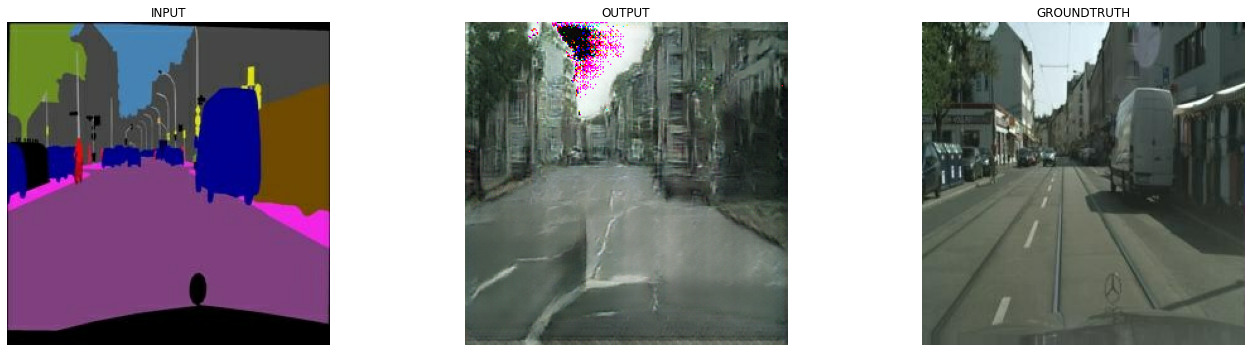

Preview of train image data 3.jpg


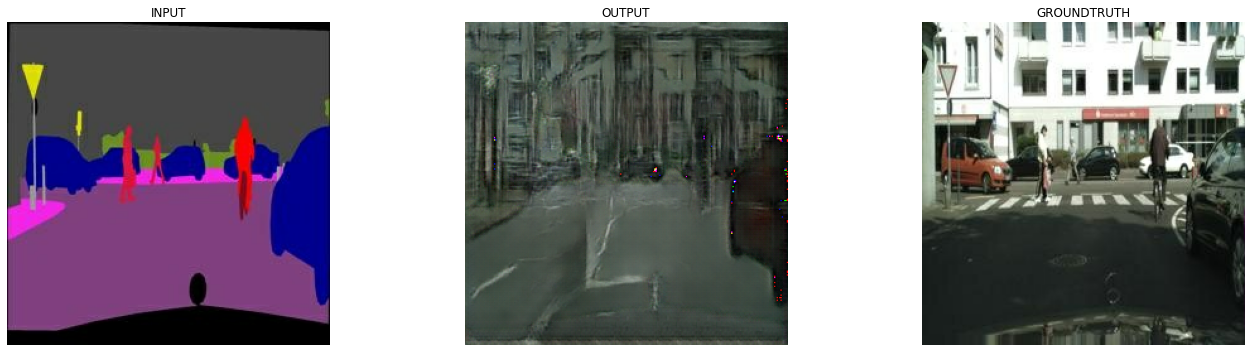

Preview of train image data 2.jpg


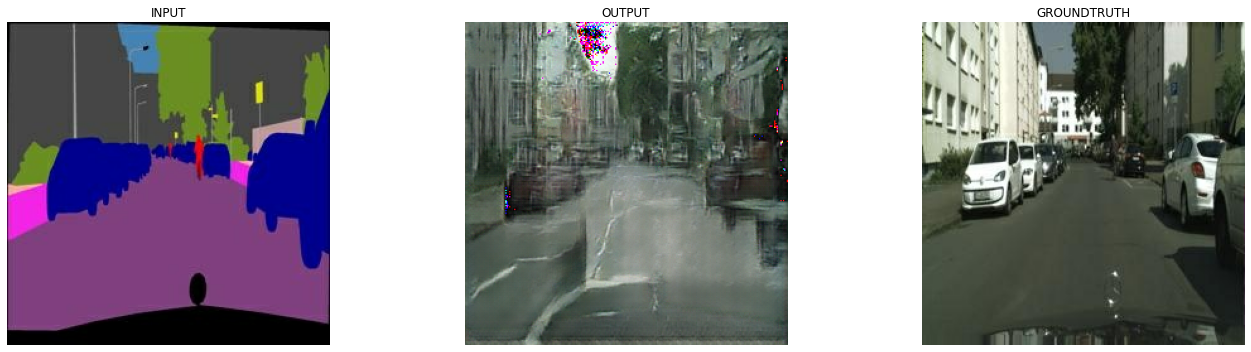

Preview of train image data 4.jpg


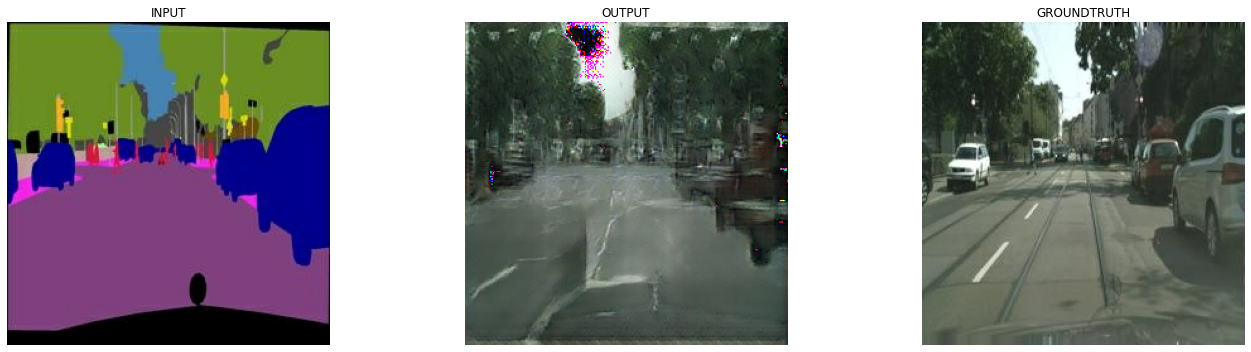

Preview of train image data 1.jpg


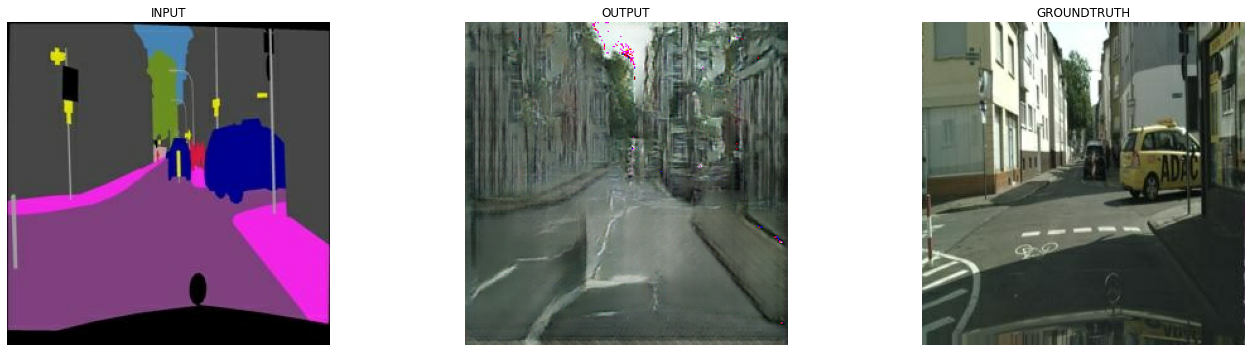

In [72]:
for i in range(TOTAL_VALID_SAMPLES):
    filename = valid_data_path + os.listdir(valid_data_path)[i]
    
    # raw image data
    raw_segmented, raw_original = load_img_data(filename)
    
    # prepare validation input (normalization)
    val_segmented = normalize_img_data(raw_segmented)

    # get predicted normalized data by trained cGAN
    predicted = generator(tf.expand_dims(val_segmented, 0))
    
    # denormalize predicted normalized data
    predicted = denormalize_img_data(predicted)
    
    
    
    # display and compare input & prediction & groundtruth
    print_divider()
    print("Preview of train image data", filename[len(valid_data_path):])
    
    result_fig = plt.figure(figsize=(20,5))
    
    result_subfig1 = result_fig.add_subplot(1, 3, 1)
    result_subfig1.imshow(raw_segmented)
    result_subfig1.set_title("INPUT")
    result_subfig1.axis("off")
    
    result_subfig2 = result_fig.add_subplot(1, 3, 2)
    result_subfig2.imshow(predicted[0])
    result_subfig2.set_title("OUTPUT")
    result_subfig2.axis("off")
    
    result_subfig3 = result_fig.add_subplot(1, 3, 3)
    result_subfig3.imshow(raw_original)
    result_subfig3.set_title("GROUNDTRUTH")
    result_subfig3.axis("off")
    
    plt.tight_layout()
    plt.show()

---
**회고록**  
이미지 학습은 확실히 EPOCHS의 영향을 많이 받는 것 같다.  
이번 프로젝ㅌ에서는 무작정 EPOCHS를 많이 돌려보느라고 시간을 할애하는 것이 가장 힘들었다 😥  

EPOCHS = 100 학습 결과, 색감은 실제와 꽤 비슷하지만 시공간이 일그러지는 듯한 왜곡 현상이 나타났다.  
좌측 하단을 향해 각진 형태로 일그러지는 것으로 보아, augmentation을 통해 한쪽으로 치우쳐지게끔 변형된 학습 데이터로부터 feature를 학습해버린 것이 아닐까 생각한다.  
차량은 일반적으로 일부를 제외하고는(라이트, 타이어 등) 단색으로 이루어진 단순한 오브젝트인데, 차량 오브젝트를 제대로 복원되지 못한 것이 아쉽다.  
또한 하늘 같은 경우에는 입력 이미지의 보라색 segment 흔적이 남아있는 것을 확인할 수 있었는데, 아마 도로(보라색)와 하늘(하늘색)의 경계 부분이 제대로 학습되지 못해서 섞여서 출력되는 것이 아닐까 생각한다.  

model training을 다시 해보면 또 다른 성능의 실험이 가능할까 싶지만, training 시간이 만만치 않다 보니 호기심에서 멈춰보는 게 좋겠다 😅